In [2]:
# import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import cv2

In [3]:
FILE = '../data/positions/depth.pkl'
ROI = '../data/positions/roi.pkl'

In [4]:
fid = open(FILE, 'rb')
data = pickle.load(fid)
fidroi = open(ROI, "rb")
roi = pickle.load(fidroi)

In [5]:
roi

{'topx': 0.16379046,
 'bottomx': 0.6768833,
 'topy': 0.17015696,
 'bottomy': 0.51462746}

In [6]:
roi_topx = int(roi['topx']*640)
roi_topy = int(roi['topy']*400)

In [7]:
len(data), roi_topx, roi_topy

(92, 104, 68)

In [8]:
depth_map = data[60]['depth_map']

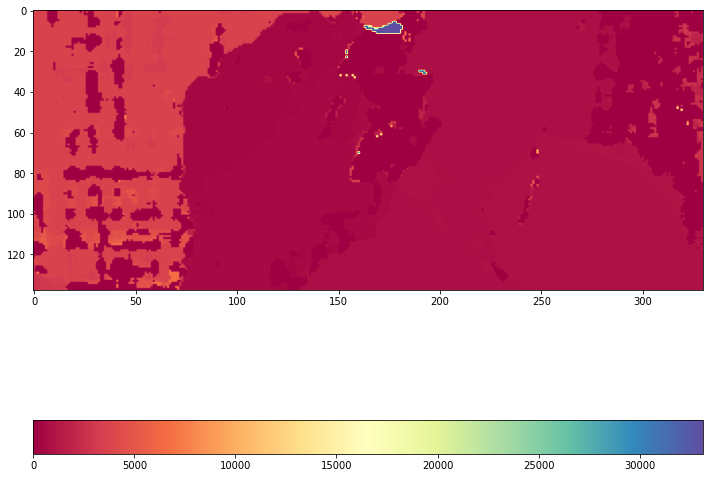

In [9]:
fig = plt.figure(figsize=(12,16))
plt.imshow(depth_map, cmap='Spectral')
plt.colorbar(orientation='horizontal')
plt.show()

In [10]:
dm = depth_map.flatten()

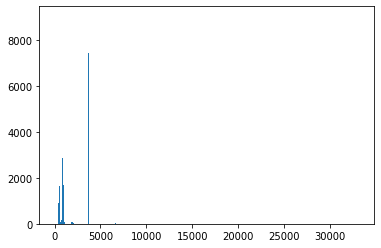

In [11]:
plt.hist(dm, bins=1000)
plt.show()

In [12]:
# filter values
dm_f = dm[dm<5000]

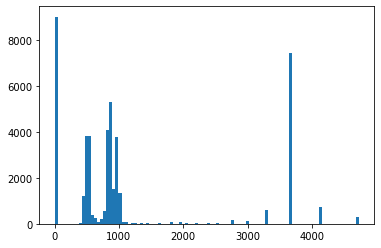

In [13]:
plt.hist(dm_f, bins=100)
plt.show()

In [14]:
# limit
lim_con = (depth_map > 425) & (depth_map < 600)
dm_l = depth_map.copy()
dm_l[~lim_con] = 2**16

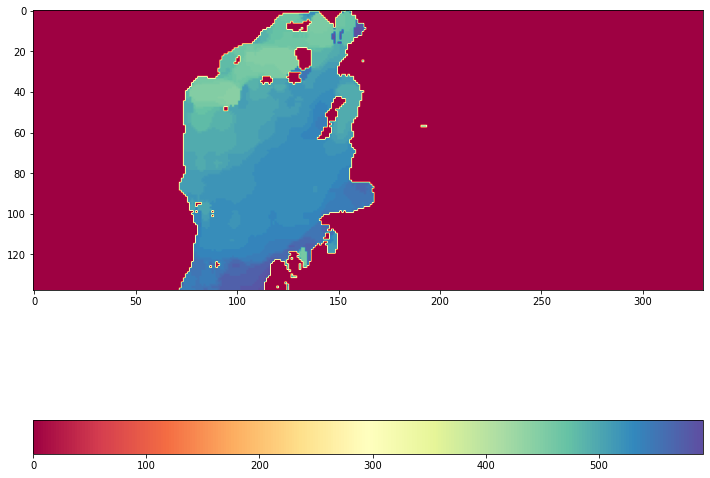

In [15]:
fig = plt.figure(figsize=(12,16))
plt.imshow(dm_l, cmap='Spectral')
plt.colorbar(orientation='horizontal')
plt.show()

In [16]:
dm_values = dm_l[lim_con]

In [17]:
np.mean(dm_values), dm_values.shape

(512.5061228952547, (9146,))

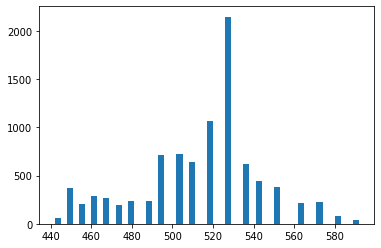

In [18]:
plt.hist(dm_values, bins=50)
plt.show()

In [19]:
# Try to get an image in RGB
# limit
lim_con = (depth_map > 425) & (depth_map < 600)
img_d = depth_map.copy()
img_d[~lim_con] = 2**16-1
idx_con_neg = np.argwhere(lim_con)

In [20]:
# create an image
rgb = np.zeros((img_d.shape[0], img_d.shape[1] , 3), np.uint8)  
rgb[lim_con] = (0,255,0)

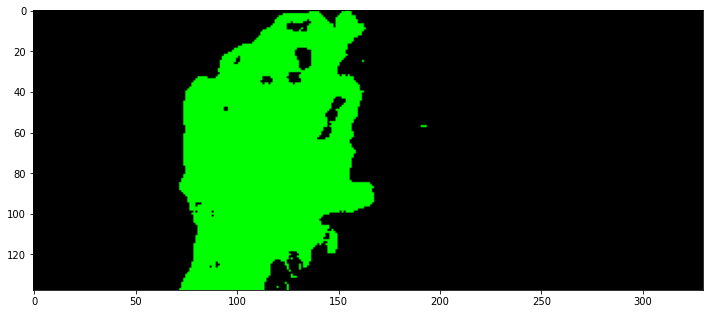

In [21]:
fig = plt.figure(figsize=(12,16))
plt.imshow(rgb)
plt.show()

In [34]:
# The idea is to transform this into a point cloud
cx = 636.09185791
cy = 357.98129272
fx = 854.11590576
fy = 854.77392578
d_m = depth_map
w, h = d_m.shape[1], d_m.shape[0]
xyz_c = []
fd = open('xyz.xyz', 'w')
# for u in range(w):
#    for v in range(h):

for v,u in idx_con_neg:     
    d = d_m[v,u]
    x_over_z = (u+roi_topx - cx)/fx
    y_over_z = (v+roi_topy - cy)/fy
    # z = d/np.sqrt(1. + x_over_z**2 + y_over_z**2)
    z = d
    # print(x,y,z)
    x = x_over_z * z
    y = y_over_z * z
    # r, g, b = rgb[v, u]
    r = 0
    g = 255
    b = 0
    xyz_c.append([x,y,z]) #,0,255,0])
    fd.write(f"{x} {y} {z} {r} {g} {b}\n")
points = np.array(xyz_c)      
fd.close()

In [44]:
np.mean(points[:,2])

512.5061228952547

In [41]:
np.mean(np.sqrt(points[:,0]**2+points[:,2]**2))

570.0810565471318

In [55]:
import open3d as o3d
from open3d.web_visualizer import draw
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)

In [56]:
draw(pcd)

WebVisualizer(window_uid='window_1')

In [ ]:
import numpy as np
import open3d as o3d
from open3d import JVisualizer

points = (np.random.rand(1000, 3) - 0.5) / 4
colors = np.random.rand(1000, 3)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector(colors)

visualizer = JVisualizer()
visualizer.add_geometry(pcd)
visualizer.show()